<h1> Symm4ml Computational Essay Final Draft</h1>
<h3> Author: Simeon Radev</h3>
<h3> Date: 15 May 2023</h3>

<h2>Introduction</h2>

<p>Cellular automata (CAs) are discrete models of computation which can use a relatively small set of pre-defined rules to simulate seemingly arbitrarily complex systems. Certain rules have even been shown to be turing complete (<a href="https://arxiv.org/pdf/0906.3248.pdf">M Cook, 2009</a>). Due to their inherent similarity to self-organizing, biological organisms, there is some significant potential for using these models of computation, or some adaptation of them, to model real-life cellular growth. However, due to the inherent complexity of many of these systems, it may be difficult to find the rules which generate them by some deterministic algorithm. As such, recent work has been done on using small neural networks to model cellular automaton (CA)-like behavior, whereby such networks learn a set of "rules", represented as model parameters, to generate some target. 

Such models are already capable of generating a target pattern from a single seed pixel input, however, in their vanilla version, they cannot reliably generate the same target in a different orientation without being explicitly retrained to do so. 

The goal of this project is to train a cellular automaton-like model that can learn the rules for generating a target, and can perform reliably under some simple transformations without having to retrain the model on such transformations. The motivation for this is that without such equivariance, the orientation of the model is an external property of the grid space, instead of an internal property of the configuration of cells/pixels/nodes inside this space. Therefore, a non-equivariant model is not fully self-organizing, however, with such equivariant versions of the network, the orientation of the model would indeed become a property of the configuration of cells/pixels/nodes.</p>

<p>In practice, however, we construct a model which achieves equivariance under a subset of all rotations (in particular, to the group $C_4$ of 90-degree rotations). This is due to the limitations of our current approach. In theory, however, using the general ideas explored in this work, one could construct CA models equivariant to the continuous group of rotations, $SO(2)$.</p>

<p>The remainder of this notebook is organized as follows:
    <ol>
        <li><i>Related Work:</i> Describes in detail the seminal work which serves as inspiration for this project, including its limitations. This section also provides a PyTorch implementation of this original model to showcase its performance, and to use it as the ground work for our equivariant upgrades. We also provide a brief overview of other papers in this sphere of using neural networks to learn CA rules.</li>
        <li><i>Background:</i> This section discusses some of the necessary ideas from group theory which will be used to construct an equivariant version of the original network.</li>
        <li><i>Methods:</i>This is one of the longer sections as it presents in great detail the practical implementation of the group theory concepts discussed in the previous section. It also provides the implementation of the equivariant model.</li>
        <li><i>Experiments:</i>This section showcases various different versions of our equivariant model and provides some detailed comparisons with the original work. It also includes several demo videos which hopefully further illustrate the power of equivariant neural networks.</li>
        <li><i>Conclusion:</i>This section overviews the main ideas of our work, and discusses the limitations of our approach including some potential ways of addressing those limitations.</li>
    </ol>
</p>

<h2>Related Work</h2>
<p>The most direct influence for this project comes from <a href="https://distill.pub/2020/growing-ca/">this 2020 Distill paper</a>, entitled <i>Growing Neural Cellular Automata</i>. This work pioneers the idea of using a small, single neural network that is applied repeatedly over a series of discrete time steps to grow the final target pattern (which, in this case, is a single image). The relevant model parameters are then updated accordingly via backpropagation-through-time.</p>

<p>
        Prior to this seminal work, there had been previous attempts at using neural networks to learn the CA rules of different systems. An IEEE paper entitled <a href="https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9534060&tag=1"><i>It's Hard For Neural Networks To Learn The Game Of Life</i></a> performs basic experimentation with neural networks to try to implement a model that can learn the rules of Conway's Game of Life, given different states of the simulation. The authors found that in order for networks to learn to simulate this system correctly they must heavily overparameterize the model beyond the smallest network that can theoretically simulate this systems. 
    <br>
    
Attempts at getting neural networks to learn basic CA rules extend as far back as 1992, when the NeurIPS paper <a href="https://proceedings.neurips.cc/paper_files/paper/1992/file/d6c651ddcd97183b2e40bc464231c962-Paper.pdf"><i>Learning Cellular Automaton Dynamics
    with Neural Networks</i></a> discusses various CNN-like models which can simulate a specific class of cellular automata rules in 1D, as defined by Wolfram's <i>Theory and Applications of Cellular Automata</i>.
    <br>
    
The 2020 Distill publication is significant however because it is the first known instance of a small, single neural network being applied repeatedly over some number of timesteps to simulate the growth process of a CA. Prior work in the area relied largely on more traditional machine learning settings, whereby cellular automata were simulated using a single application of a large neural network, as opposed to repeated applications of a single, condensed network. The inspiration for the latter approach seems to come from biological processes and is a more natural way of approximating the behaviour of cellular automaton dynamics, as it represents a self-contained, single rule set that is universally applied to the entire system. 
</p>

<p>As a result of the successes of this approach, there have been many different continuations of this work. As an example, a 2021 NeurIPS paper, <a href="https://proceedings.neurips.cc/paper/2021/hash/af87f7cdcda223c41c3f3ef05a3aaeea-Abstract.html"><i>Learning Graph Cellular Automata</i></a> extends the idea of repeated applications of a single neural network to graphical structures. In the NeurIPS paper, a graph is distorted and the distortion is used as a seed input into a cellular automaton-like model, where repeated applications of this single model allows for the distorted graph to converge to some target shape.
</p>

<p>Even more recently, ICLR's 2022 conference published <a href="https://openreview.net/pdf?id=7fFO4cMBx_9"><i>Variational Neural Cellular Automata</i></a>, which uses a CA-based network as the decoder of a VAE. This extends the original Distill work by creating a network architecture which is capable of generating, or, "growing", multiple different targets, instead of being overfit on a single target.
</p>

<p>As we can see, the success of the original 2020 Distill publication which inspired this new approach to learning CA rules has spurred some active research in the area. Nevertheless, there are some drawbacks to the initial approach. In particular, the original model is presented as simulating a self-organizing process (namely, that of an "organisms" growth from a starting state to a final target state through intrinsic properties). However, the model is only capable of generating the target in the particular orientation in which it was trained. This means that the model's ability to successfully grow and persist is dependent on external properties of its space, as opposed to the intrinsic states of its cells. Thus, if we wanted to grow the same pattern in a different orientation, the naive approach would not allow for that. To address this issue, the authors do provide an experiment whereby the target image can be grown in a different orientation by taking in a rotation angle as an additional input. However this still poses certain limitation which will be further illustrated below with experiments.
</p>

<p>Finally, the same group of authors of the original publication presented a new paper in 2022, currently on on arxiv, called <a href="https://arxiv.org/pdf/2205.01681.pdf"><i>Growing Isotropic Neural Cellular Automata</i></a>. This latest work discusses the original implementation's problem of anisotropy and suggests various methods for fixing it. In particular, they make the anology that the original model's dependence on external properties of the space are analogous to a real-life organism being solely capable of growing while facing north. As a solution to this, they propose a somewhat complex approach of modifying the loss function from a simple MSE to a significantly more complicated one. While they do not provide their code for reproduction, this approach feels like an overly complicated and more unnatural solution to achieve model equivariance. The purpose of this project is therefore to present a first-principles approach, which constrains the architecture of the model to be equivariant without having to manipulate the loss function in any way.
</p>

<p>All of the equivariant aspects of our architecture come from the <a href="https://github.com/QUVA-Lab/e2cnn">e2cnn</a> library. 

<h3>Overview of original implementation</h3>

Because our work relies heavily on the original architecture of the inspiration behind this work, we present a brief overview of the important concepts introduced by the <a href="https://distill.pub/2020/growing-ca/">2020 Distill work</a>, as well as an implementation of their model in PyTorch (the original is in Tensorflow). We believe it important to present this here because the fundamental architectural design of the original work will heavily guide our design and understanding of its equivariant descendant.

Furthermore, a lot of the implementation provided here (such as the training class), will remain unchanged throughout the rest of the notebook as it is not the main focus of this project.

To start, we first define some necessary imports (note the dependance on a custom python module `utils` which includes helper functions for processing and displaying our work, but the relevant pieces of code should be wholly self-contained within this notebook):

device is cuda:2


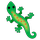

In [20]:
import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'

# PyTorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F

# Equivariant library
import e2cnn
from e2cnn import gspaces

# Other dependencies 
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import math
import PIL.Image, PIL.ImageDraw
import time

# Notebook dependencies
from IPython.display import clear_output, Image

# Import necessary functions from personal utils file
from utils import *

# For file reloading
import importlib
import sys
importlib.reload(sys.modules['utils'])
from utils import *

# Get access to GPU
device_id = 2
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
print('device is {}'.format(device))

## Global parameters used throughout
CHANNEL_N = 16
TARGET_PADDING = 16
BATCH_SIZE = 8
HIDDEN_SIZE = 128
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🦎"

USE_PATTERN_POOL = True # set in "persistent" mode

# Load and imshow the target image
target_img = load_emoji(TARGET_EMOJI)
imshow(target_img)

In [5]:
# Toggle this to train the below models instead 
TRAIN = False

For now, we have made all necessary package imports and have defined some globals parameters. These parameters will remain unchanged as they are not the focus of this project, and so they are the same as the defaults defined in the original implementation.

Below, we show the seed image that is used by the original implementation, along with the target image. As we can see, it is just a single dot in the center of the image, with the entire grid initialized to zeroes, except for the center pixel which is initialized to ones (except for the first three RGB channels).

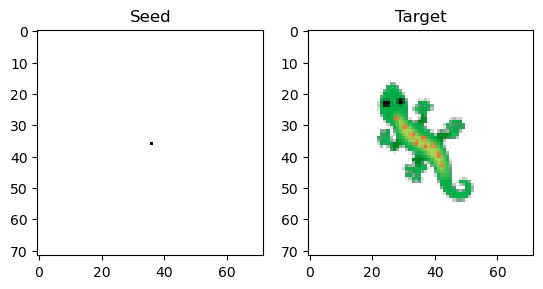

In [6]:
seed, pad_target = make_seed(target_img)
x0 = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0) # augment the seed pixel with a batch dimension

Now we need to define a class to contain the original CA model architecture, which is a close implementation of the original paper's model. Figure 1 below visualizes the basic concept:

<figure>
  <img src="images/original_model.svg" alt="Original Model Architecture" style="width:100%">
    <figcaption><b>Figure 1:</b> Original model architecture</figcaption>
</figure>

On a high level, the model works by repeatedly updating each cell/pixel in the input image according to information sourced from that pixel's 3x3 neighbourhood. This is done to reflect the local message-passing nature of a traditional cellular automaton. 

As a reminder, an individual cell $c$ in a cellular automaton determines its state at time $t+1$ using the information from its current state value at time $t$, and the state value of its neighbours, also at time $t$. The rule set of a cellular automata then defines how to use this information acquired at time $t$ to produce an update for the cell $c$ at time $t+1$. 

In a similar manner, the model architecture is devised to have two main components. The first acquires the information from a particular cell and its neighbours, and the second uses this information and processes it (applies a CA "rule") to produce an update for that cell.

To do this, the model extracts a single 3x3 patch from the input image, and applies three different filters to that patch in order to generate a one-dimensional perception vector that contains all the information a cell and its neighbours. In the original implementation the authors use hardcoded filters to do generate this perception vector. The identity matrix captures the state of the cell at time $t$, and the $Sobel_X$ and $Sobel_Y$ filters capture relevant information from the cell's neighbours (the abstract intuition for the usage of sobel filters is that they approximate gradients in discrete cases).

Once the perception vector is generated, the CA "rule" can be applied to produce an update for the center pixel of the patch. In practice, we use a neural network to learn this "rule", which is implemented as two dense layers in PyTorch, with a single ReLU activation used in between. We do not go into further detail here as this part of the network is extensively detailed in the original publication and, as we will see, will ultimately end up irrelevent to the goal of our project.

Given this intuition, we can now provide our implementation of the above model. The most relevant component of the following code cell is the `perceive` method of the `CAModelOriginal` class, which defines how the network should "perceive" a cell's neighbourhood. As illustrated in the Figure 1 above, three hardcoded filters are applied to each 3x3 patch of the input image. Of course, for implementation purposes, this computation is parallelized and the actual filter application is performed by PyTorch's convolution operation in 2D.

The `forward` method of that same class implements the "Standard Dense Layer" described in the above graphic, and largely follows the implementation of the original work (albeit translated to PyTorch).

<!-- We should also mention that the specific details of the forward pass of the model, like stochastic updates, will be used throughout, but are not the focus of this work and therefore will not be discussed in detail. Our main focus with this work is in examining the kinds of functions which can be used to generate perception vectors based on a cell's 3x3 local neighbourhood, and how to constrain that function space to be invariant to certain transformations. -->

In [7]:
# Define Model

class CAModelOriginal(nn.Module):
  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    conv1 = nn.Conv2d(in_channels=self.channel_n*3, out_channels=128, kernel_size=1)
    conv2 = nn.Conv2d(in_channels=128, out_channels=self.channel_n, kernel_size=1)
    
    # Apply "do-nothing" initial behavior (these are the default initializations in TF)
    torch.nn.init.zeros_(conv2.weight)
    torch.nn.init.zeros_(conv1.bias)
    torch.nn.init.zeros_(conv2.bias)

    self.dmodel = nn.Sequential(
        conv1,
        nn.ReLU(),
        conv2,
    )
    
  def perceive(self, x, angle=0.0):
    """Pytorch does convolutions differently. Reshape accordingly
      input is (batch, in_channels, H, W)
      kernel is (filter_height, filter_width, in_channels, channel_multiplier) in TF
      but should be (out_channels, in_channels / groups, H, W) in Torch
    """
    identify = torch.as_tensor([0, 1, 0], dtype=torch.float32)
    identify = torch.outer(identify, identify)
    dx = torch.as_tensor(np.outer([1, 2, 1], [-1, 0, 1]) / 8.0, dtype=torch.float32) # Sobel filter
    dy = dx.T
    c, s = torch.cos(torch.tensor(angle)), torch.sin(torch.tensor(angle))
    stacked_filters = torch.stack((identify, c*dx-s*dy, s*dx+c*dy)).to(device)
    kernel = stacked_filters.tile((self.channel_n, 1, 1))
    y = F.conv2d(x, kernel[:, None, :, :], padding='same', groups=self.channel_n)
    return y

  def forward(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    x = torch.permute(x, (0, 3, 1, 2)) # make it shape [batch_size, in_channels, H, W]
    pre_life_mask = get_living_mask(x)

    y = self.perceive(x, angle) # y should be on device
    dx = self.dmodel(y)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = torch.rand(x[:, :1, :, :].shape, device=device, dtype=torch.float32) <= fire_rate
    x = x + dx * update_mask

    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    result = x * life_mask
    return torch.permute(result, (0, 2, 3, 1)) # send it back [batch_size, H, W, in_channels]

CAModelOriginal().dmodel

Sequential(
  (0): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
)

Below is the training class which we define. It is fully decoupled from the equivariant nature of the input model, so this will be the same training instance we use throughout this notebook to train both equivariant and non-equivariant CA models. Figure 2 provides a brief illustration of the training methodology. A key difference between this training loop and more traditional ones is that here we apply the same model (described above) repeatedly for some $N$ number of steps (where $N$ is an integer drawn at random from [64, 96], just as in the original work).

The final output of the network after these $N$ steps is then compared with the target image using an $L_2$ loss, and the parameters of the model are updated via backpropagation-through-time. This training scheme remains unchanged throughout this notebook.

<figure>
  <img src="images/training_scheme.svg" alt="Training Scheme" style="width:100%">
    <figcaption><b>Figure 2:</b> Training scheme of CA network</figcaption>
</figure>

In [8]:
# Define training class

class Train:
    def __init__(self, ca_model, seed, target, lr=2e-3):
        """Initialize training object with model to train, seed and target

        :param ca_model: PyTorch model class object (instantiated)
        :param seed: PyTorch tensor of shape (H, W, C), initial seed to start training
        :param target: PyTorch tensor of shape (H, W, C), target image to learn
        """
        self.ca = ca_model
        self.seed = seed

        # Augment target tensor with batch dimension
        self.target = torch.repeat_interleave(target[None, ...], BATCH_SIZE, dim=0)
        self.lr = lr

        # Initialize optimizer with lr scheduler
        self.optim = torch.optim.Adam(self.ca.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optim, milestones=[4000], gamma=0.25)

        # Pool of training samples for "persistent" training mode
        self.pool = SamplePool(x=torch.repeat_interleave(self.seed[None, ...], POOL_SIZE, dim=0))    

        # Log the training progress
        self.loss_log = []
    
    def train(self, n_steps=1001):
        """Train the model stored in `self.ca` for `n_steps` training steps

        :param n_steps: int, Number of training steps
        :return: list, loss history         
        """
        start_time = time.time() # time training run
        
        for i in range(n_steps):
            
            # Very similar to original TF implementation
            if USE_PATTERN_POOL:
                batch = self.pool.sample(BATCH_SIZE)
                x0 = batch.x.detach() # batch.x requires grads by default (hence the .detach())

                loss_rank = self._loss_f(x0, self.target).argsort(descending=True)
                x0 = x0[list(loss_rank.detach().cpu().numpy())]
                x0[:1] = seed # to prevent catastrophic forgetting
            else:
                x0 = torch.repeat_interleave(self.seed[None, ...], BATCH_SIZE, 0)

            # Run through a single training step of the model (note this performs many updates)
            x, loss = self._train_step(x0)
            self.loss_log.append(loss)

            # Update pool
            if USE_PATTERN_POOL:
                batch.x[:] = x
                batch.commit()

            # Printing
            if i % 100 == 0:
                clear_output()

                # Visualize batch
                visualize_batch(x0.detach().cpu(), x.detach().cpu(), i)

                # Plot loss
                plot_loss(self.loss_log)

            print('\r step: %d, log10(loss): %.3f'%(len(self.loss_log), np.log10(loss)), end='')
        
        elapsed_time = np.round((time.time() - start_time) / 60, decimals=4)
        print(f'\nElapsed time for training run on {n_steps} steps: {elapsed_time}')
        
        return self.loss_log, elapsed_time
        
    def _train_step(self, x):
        """Perform the update step some random number of times"""
        
        iter_n = np.random.randint(64, 97, dtype=np.int32)
        for _ in range(iter_n):
            # Forward pass of model
            x = self.ca(x)
            
        # Compute loss (note we must take the mean across the batch dimension)
        loss = self._loss_f(x, self.target).mean()
        
        # Compute gradients
        loss.backward()

        # Apply L2 normalization to parameter gradients as per original paper
        for p in self.ca.parameters():
            if p.grad is not None:
                p.grad = p.grad / (p.grad.norm() + 1e-8) 

        # Update parameters
        self.optim.step()

        # Clear previous gradients accumulated on parameters
        self.optim.zero_grad()

        # Update learning rate step
        self.scheduler.step()

        return x, loss.item()

    def _loss_f(self, output, target):
        """Custom l2 loss function. Compute mean-squared errors across
            batch dimension to be sorted for pooling."""
        return torch.square(to_rgba(output) - target).mean(dim=(-2, -3, -1))


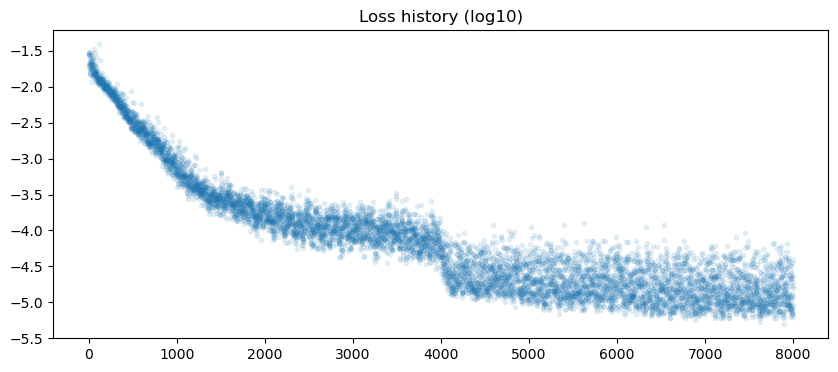

Training took approximately 19.0115 minutes


In [9]:
# Load stored model

if not TRAIN:
    ca_original = load_ca_model(CAModelOriginal, 'original_model', device=device)
    loss_log_original = load_np_array('original_model')
    elapsed_time_original = load_np_array('original_model', foldername='train_time')

    plot_loss(loss_log_original)
    print(f"Training took approximately {elapsed_time_original.item()} minutes")

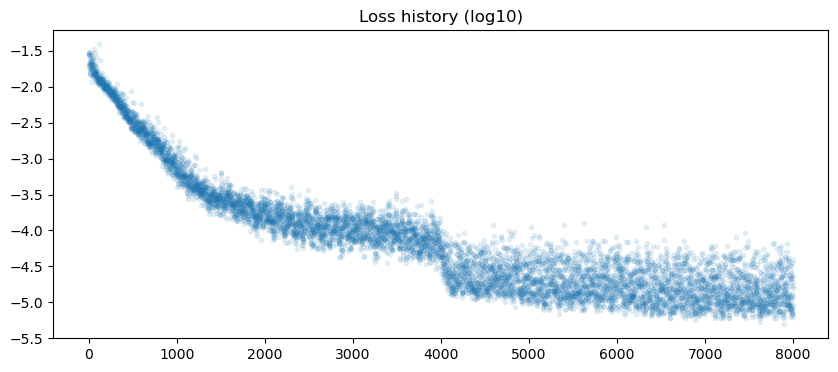

Training took approximately 19.0115 minutes
CPU times: user 231 ms, sys: 5.37 ms, total: 236 ms
Wall time: 248 ms


In [10]:
%%time

# Original CA implementation training instance
if TRAIN:
    ca_original = CAModelOriginal().to(device)
    train_original = Train(ca_original, seed.to(device), pad_target.to(device))

    loss_log_original, elapsed_time_original = train_original.train(n_steps=8001)

    # Save stuff
    filename = "original_model"
    save_ca_model(ca_original, filename)
    save_np_array(loss_log_original, filename)
    save_np_array(elapsed_time_original, filename, foldername="train_time")
else:
    ca_original = load_ca_model(CAModelOriginal, 'original_model', device=device)
    loss_log_original = load_np_array('original_model')
    elapsed_time_original = load_np_array('original_model', foldername='train_time')

    plot_loss(loss_log_original)
    print(f"Training took approximately {elapsed_time_original.item()} minutes")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


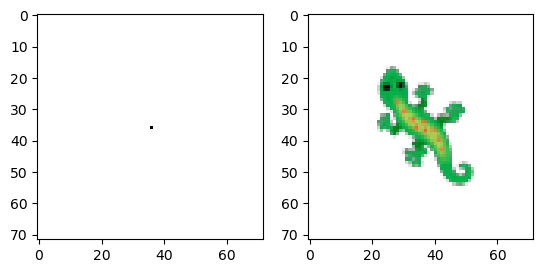

In [11]:
_ = simulate_model(ca_original, seed.unsqueeze(0), 90, device=device)

In [8]:
# Note, to change the length of the video (and the number of update steps to perform), change the `n_steps` variable

make_video(models=[ca_original], seed=seed, n_steps=120, video_name="original_ca", device=device)
mvp.ipython_display('original_ca.mp4')

100%|██████████████████████████████████████████████████████████████████████████| 120/120 [00:01<00:00, 91.38it/s]


Moviepy - Building video original_ca.mp4.
Moviepy - Writing video original_ca.mp4



Moviepy - Done !
Moviepy - video ready original_ca.mp4


We observe that the original model is able to reconstruct the target image quite successfully, as expected. However, as described above, the current model is limited in that it does not represent a fully self-organizing process, as the success of the model's growth process is dependent on external factors not intrinsic to the model itself. 

The original publication does describe one possible method for growing the target in an orientation other than the one in which it was trained, by multiplying the sobel filters by a rotation matrix parameterized by some angle, theta. We also implement this method in the code above and visualize its performance below:

In [9]:
# In the below, we call a function which generates a video given a list of angles with which to rotate the target, 
# as well as the corresponding time steps at which to do so. 

models = [ca_original]
time_steps = [0]
angles = [90]
make_video_with_rotations(models=models, seed=seed, n_steps=120, time_steps=time_steps, angles=angles, device=device)

print(f"\nShowing growth of target when rotations {angles} applied at update steps {time_steps}")
mvp.ipython_display('original_rot.mp4')

100%|█████████████████████████████████████████████████████████████████████████| 120/120 [00:01<00:00, 107.79it/s]


Moviepy - Building video original_rot.mp4.
Moviepy - Writing video original_rot.mp4



Moviepy - Done !
Moviepy - video ready original_rot.mp4

Showing growth of target when rotations [90] applied at update steps [0]


As we can see, the above video illustrates that the naive approach of using rotation matrices to grow the target in a different orientation works when the image is rotated from the start. 

However, as we can see from the demo below, when multiple rotations are performed during the growth process of the target, the reconstruction fails quite spectacularly:

In [10]:
models = [ca_original]
time_steps = [20, 50, 70]
angles = [90, 180, 270]
name = 'original_rot_fail.mp4'
make_video_with_rotations(models=models, seed=seed, n_steps=220, time_steps=time_steps, angles=angles, video_name=name, device=device)

print(f"\nShowing growth of target when rotations {angles} applied at update steps {time_steps}")
mvp.ipython_display(name)

100%|█████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 278.55it/s]


Moviepy - Building video original_rot_fail.mp4.
Moviepy - Writing video original_rot_fail.mp4



Moviepy - Done !
Moviepy - video ready original_rot_fail.mp4

Showing growth of target when rotations [90, 180, 270] applied at update steps [20, 50, 70]


From the above demos we see that although applying a rotation matrix does appear to work in some cases, it does tend to fail in many trivial situations (most notably when rotations are applied during the model's growth process). This can be further analyzed with the demo presented by the <a href="https://distill.pub/2020/growing-ca/">original blog post</a> on Distill.

The aim of this project is therefore to construct a more robust method for growing the target image in a new orientation from the one in which it was trained by using ideas from  geometric deep learning related to equivariant and invariant models, which are further discussed below.

<h2>Background</h2>

<p>In the above sections we introduce the concept of cellular automata and some potential reasons for studying them. We then provide an overview of some of the more successful attempts at constructing neural networks to simulate the behaviour of such CAs, by learning a set of "rules" (or, in practice, weight matrices), that can grow some target image. We additionally demonstrate some limitations to the previous approaches, the most obvious one being that in the original implementation, the target can only be grown in the orientation in which it was trained, which is quite limiting for obvious reasons. Additionally, a naive attempt at solving this problem by rotating the perceptive field via a rotation matrix, also fails, and the model is still incapable of sustaining its own growth process after multiple rotations. We showcase a video above ('original_rot_fail.mp4') that demonstrates what happens to the model when it is grown for some number of steps, rotated, grown again, and then rotated again, etc. The demo makes clear that the current version of the model cannot sustain such perturbations. To be fair, we additionally try to select rotation angles such that interpolation would not be an issue (such as 90-degree rotations), and yet the issue persists. This indicates that the model is unable to sustain its growth process if its cell states are resampled in a rotated coordinate frame, which is a weakness observed by the same authors in a follow-up paper (Mordvintsev, 2022). Although that updated paper does present one potential solution to this problem, via loss function manipulation, we present an alternative methodology that solves this problem from first principles, without any modifications to the loss function or training scheme.
</p>

We will now describe our approach to constructing an equivariant neural cellular automata. As a review, an equivariant model is one which produces an output that transforms according to the transformation of its output. More concretely, an equivariant model (modeled as a function $F$), satisfies:  <br><br>
    $$ T_\text{out}[g] \ \big ( F(x) \big )\ =\ F \ \big ( T_\text{in}[g] \ (x) \big ), \quad \forall g \in G,$$

where $g$ is an element from the group $G$, $T_\text{out}[g]$ is the transformation of the model's output under the action of the group element $g \in G$, and $T_\text{in}[g]$ is, similarly, the transformation of the model's input under the action of that same group element.

For our purposes, both input and output transformations are rotations in $\mathbb{R}^2$, which implies that we must select a group, $G$, which contains the set of rotations to which we want our model to exhibit equivariance. A fully isotropic cellular automata would require that our model be equivariant to the group $SO(2)$, but as this is a continuous group we would need to define our feature fields to transform under irreducible representations (feature fields are a formalized notion of data in 2D, i.e. images, which is described as a signal on $\mathbb{R}^2$). This would require additional experimentation in selecting up to what order irreps to use, which, in turn, can demand longer training times and is beyond the scope of this project. 

Instead, we choose to make our model equivariant to the cyclic group of rotations $C_N$. Note that this is a subgroup of $SO(2)$ and is also isomorphic to $\mathbb{Z}/n\mathbb{Z}$ (the group of integers modulo $N$).

In practice, we select $N$ to be somewhere between 4 and 8 as the computational requirements increase as the group cardinality increases. On a theoretical level, though, the concepts remain quite similar. 

As we will see, in order to make our whole model equivariant to $C_N$, it is sufficient to construct an invariant perceptive field. This is due to the local message-passing of the model, whereby any particular cell's update is calculated using only information from its immediate 3x3 neighbourhood. As we can see from Figure 3 below, any arbitrary patch selected from the target image rotates isotropically along with the target. More concretely, an arbitrary 3x3 neighbourhood in the head of the lizard, for example, will have the same individual cell values regardless of the orientation of the overall lizard, assuming an ideal scenario without any interpolation.

<figure>
  <img src="images/rotated_target.svg" alt="Patch rotates with target" style="width:100%">
    <figcaption><b>Figure 3:</b> Any particular patch from the target rotates along with the target</figcaption>
</figure>    
    
Furthermore, for any particular 3x3 neighbourhood of cells, the value of the center cell remains unchanged regardless of the orientation of the overall neighbourhood patch. This is highlighted in Figure 4 below.

<figure>
  <img src="images/patch_enlarged.svg" alt="Enlarged patch rotations" style="width:100%">
    <figcaption><b>Figure 4:</b> Rotations of an individual 3x3 patch should not change the value of the center pixel</figcaption>
</figure>    

Therefore, we want to construct a <i>learnable</i> perception layer of the model which is <i>invariant</i> to the cyclic group $C_N$. This perception layer will be implemented as an invariant convolutional layer, as shown in Figure 5 below.

<figure>
  <img src="images/equivariant_model.svg" alt="Equivariant model architecture" style="width:100%">
    <figcaption><b>Figure 5:</b> Equivariant model architecture</figcaption>
</figure>    
<br>
As a review, an invariant function $F$, is one which satisfies:
$$ F(x) \ =\ F \ \big ( T_\text{in}[g] \ (x) \big ), \quad \forall g \in G.$$

Conceptually, this means that the output of the function remains unchanged when its input is transformed by a group action. This is the behaviour we want our perceptive field to have.


<h2>Methods</h2> 

In this section we will describe, and implement, a cellular automata model using the modified perception layer discussed above. To implement invariance, we use the <a href="https://github.com/QUVA-Lab/e2cnn">e2cnn</a> library. As such, we will first provide a brief overview of the basic operations of this library, which will also guide our selection of representations to use.

We begin by defining a group action on the input space $\mathbb{R}^2$:

In [13]:
x = torch.randn(1, 3, 2, 2)
r2_act = gspaces.Rot2dOnR2(N=4)

Now, we need to define how we want our feature fields to transform (as in, the representation according to which our fields will transform).

As we are working with images in 2D, we can model the scalar pixel values by the <i>trivial representation</i>, which maps every scalar to itself $\Rightarrow \rho_\text{trivial}: G \rightarrow GL(1)$. This gives us the input field type.

We also need to select the representations according to which the internal layers of the model will transform. For more expressivity, we will choose features which transform under the <i>regular representation</i> $\Rightarrow \rho_\text{regular}: G \rightarrow GL(\mathbb{R}^{|G|})$, as they can encode for any function on the group. In practice, we can stack these feature fields transforming under the regular representation for more expressive power (this is analogous to augmenting the number of hidden channels in a conventional neural layer). This stacked feature space will thus transform according the direct sum of the regular representations of the group. Furthermore, the regular representation is a good choice because it also decomposes into the direct sum of all of the irreducible representations of a group, which should provide for more expressive power.

We should note, though, that the regular representation does not output scalar values, and since we want our perception vector to be passed into a standard MLP, we must map the output of the regular representation to a scalar field to produce invariant predictons. This is done by pooling over the group.

The below cell defines the above in code using the e2cnn library:

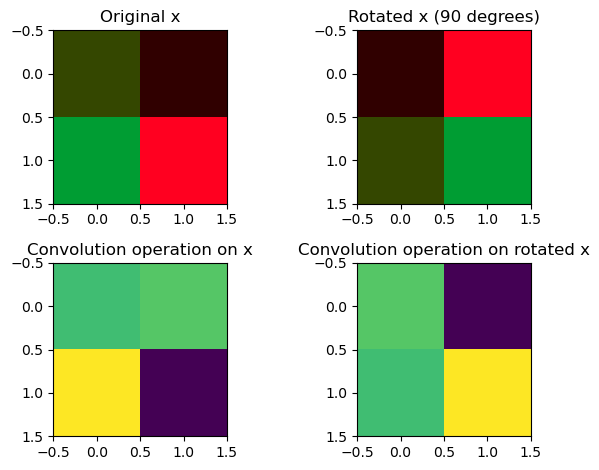

In [14]:
# The input is a scalar field
feat_type_trivial = e2cnn.nn.FieldType(r2_act, 3 * [r2_act.trivial_repr])

# Internally, our feature fields transform under the regular representation
feat_type = e2cnn.nn.FieldType(r2_act, 1 * [r2_act.regular_repr])

# Wrap the input into the library's conventions
geometric_x = e2cnn.nn.GeometricTensor(x, feat_type_trivial)

# Apply a single 90-degree rotation to the input
transformed_x = geometric_x.transform(1)

# Construct invariant map back to scalars
gpool = e2cnn.nn.GroupPooling(feat_type)

# Define convolution operation
out = e2cnn.nn.R2Conv(feat_type_trivial, feat_type, kernel_size=3, padding=(1,1), \
                      groups=1).cpu()

# Pass the input through the convolution layer
geometric_y = gpool(out(geometric_x))
output = geometric_y.tensor[0, ...].permute(1, 2, 0).detach()

# Pass rotated input through convolution layer
transformed_y = gpool(out(transformed_x)).tensor
transformed_output = transformed_y[0, ...].permute(1, 2, 0).detach()

# Plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.imshow(clip_tensor(x[0, ...].permute(1, 2, 0)))
ax2.imshow(clip_tensor(transformed_x.tensor[0, ...].permute(1, 2, 0).detach()))
ax3.imshow(output)
ax4.imshow(transformed_output)

ax1.set_title("Original x")
ax2.set_title("Rotated x (90 degrees)")
ax3.set_title("Convolution operation on x")
ax4.set_title("Convolution operation on rotated x")

fig.tight_layout()
fig.show()

The above demo showcases a simple convolution operation being applied to the same input in two different orientations. As we can see, when the input rotates by 90 degrees, the output of the convolution rotates accordingly. This exhibits the equivariance property we want our model to have. 

<p>Note that all of the concepts described above will be used throughout the remainder of this notebook.</p>
    
<p>To implement an equivariant CA, we first define a new model class with an invariant perception layer. This class lets the caller select between the trivial and regular representations to use in the hidden layer of the model. As the trivial representation already produces scalras (i.e. invariant features), we do not need to define any invariant map to scalar features. However, as we will see, the trivial representation is not expressive enough to capture the necessary information about a cell's local neighbourhood, which motivates the need for a more expressive feature field that transforms under the regular representation.</p>

Note that the perception layer is now a learnable convolutional layer, constructed with invariance in mind.

In [12]:
# Define model class with equivariant features

class CAModel(nn.Module):
    def __init__(self, 
                 N=4,
                 hidden_repr='trivial', 
                 hidden_repr_size=48, 
                 channel_n=CHANNEL_N, 
                 hidden_size=HIDDEN_SIZE):
        """Defines the model class for our CA.

        :param N: int, number of rotations to define for our group C_N
        :param hidden_repr: str, representation to use in the hidden layer
        :param hidden_repr_size: int, number of feature fields to use in our hidden layer
        :param channel_n: int, number of channels for our target (default to 16)
        :param hidden_size: int, hidden size of our dense layer (after equivariant component)
        """
        super().__init__()
        self.hidden_repr_size = hidden_repr_size
        self.channel_n = channel_n

        ## Construct learnable, equivariant perception layer

        # First we define the action on our input space (in this case rotation on C_N)
        r2_act = gspaces.Rot2dOnR2(N)

        # Define the transformation feature field of our input (trivial for scalars)
        in_type = e2cnn.nn.FieldType(r2_act, self.channel_n*[r2_act.trivial_repr])

        # Define the transformation feature field of our hidden layers
        if hidden_repr == 'trivial':
            hidden_repr = r2_act.trivial_repr
        elif hidden_repr == 'regular':
            hidden_repr = r2_act.regular_repr
        out_type = e2cnn.nn.FieldType(r2_act, hidden_repr_size*[hidden_repr])

        # Finally, instantiate an equivariant convolutional layer to map from in_type to out_type feature fields
        equivariant_perception = e2cnn.nn.R2Conv(in_type, out_type, kernel_size=3, \
                                                 padding=(1,1), groups=self.channel_n)

        # To compute invariant features for our MLP we need an invariant map (in this case pooling over group)
        self.gpool = e2cnn.nn.GroupPooling(out_type)

        ## Construct regular dense layer (this is the MLP - modeled closely to original)

        conv1 = nn.Conv2d(in_channels=hidden_repr_size, out_channels=hidden_size, kernel_size=1)
        conv2 = nn.Conv2d(in_channels=hidden_size, out_channels=self.channel_n, kernel_size=1)

        # Apply "do-nothing" initial behaviour - nothing to do with equivariance
        torch.nn.init.zeros_(conv1.bias)
        torch.nn.init.zeros_(conv2.bias)
        torch.nn.init.zeros_(conv2.weight)

        ## Create both sequential modules

        self.input_type = in_type
        self.perceive = e2cnn.nn.SequentialModule(equivariant_perception)
        self.dmodel = nn.Sequential(
            conv1,
            nn.ReLU(),
            conv2,
        )
    
    def forward(self, x):
        """Forward pass of model, equivalent to a single update step of our CA. 
            Note that we need to use PyTorch shaping conventions here.
            This means making our data of shape [B, C, H, W] instead of the TF/matplotlib
            convention of [B, H, W, C].

        :param x: PyTorch tensor, input data to push through our model 
        :return: PyTorch tensor, updated state of data after a single step
        """
        x = x.permute(0, 3, 1, 2) # make x have shape [B, C, H, W]
        pre_life_mask = get_living_mask(x) # mask "dead" cells
        
        # Construct "geometric" tensor for use with e2cnn library and pass through perception
        geometric_x = e2cnn.nn.GeometricTensor(x, self.input_type)
        geometric_y = self.perceive(geometric_x)
        
        # Pool over the group to construct invariant features and pass into MLP
        y = self.gpool(geometric_y).tensor
        dx = self.dmodel(y)
        
        # Mask out some updates to simulate asynchronous CA updates (as per original)
        update_mask = torch.rand(x[:, :1, :, :].shape, \
                                 device=device, dtype=torch.float32) <= CELL_FIRE_RATE
        x = x + dx * update_mask
        post_life_mask = get_living_mask(x)
        life_mask = pre_life_mask & post_life_mask
        return torch.permute(x * life_mask, (0, 2, 3, 1)) # send it back [B, H, W, C]

ca = CAModel(hidden_repr='regular')
print(ca.perceive)
print(ca.dmodel)

SequentialModule(
  (0): R2Conv([4-Rotations: {irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0}], [4-Rotations: {regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular}], kernel_size=3, stride=1, padding=(1, 1), groups=16)
)
Sequential(
  (0): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
)


Note that our training class is the same as before. However, we do define several helper functions which will be useful in analyzing our results.

Additionally, we want to construct an asymmetric seed, so that the model can detect transformations of its input.

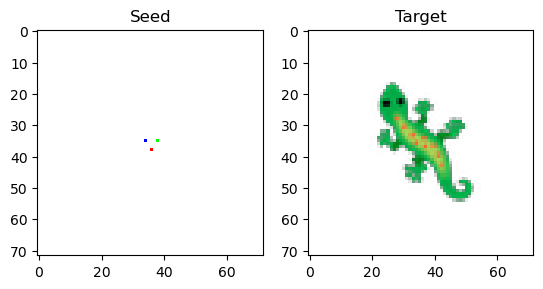

In [13]:
seed, pad_target = make_seed(target_img, radius=2)

In [14]:
def rotate(tensor, N, element):
    """Takes a PyTorch tensor and apply an element transformation
    from the cyclic group C_N, returning a PyTorch tensor again.
    
    :param tensor: PyTorch tensor, input tensor to rotate. 
    :param N: int, Number of cyclic group elements in the group C_N
    :param element: int, which element to select form the cyclic group C_N
    :return: PyTorch tensor, rotated version of input tensor
    """
    if len(tensor.shape) < 4:
        tensor = tensor.unsqueeze(0)
    n_channels = tensor.shape[-1] # extract the number of channels
    r2_act = gspaces.Rot2dOnR2(N)
    in_type = e2cnn.nn.FieldType(r2_act, n_channels*[r2_act.trivial_repr])
    geometric_tensor = e2cnn.nn.GeometricTensor(tensor.permute(0, -1, 1, 2), in_type)
    return geometric_tensor.transform(element).tensor.permute(0, 2, 3, 1)

def plot_tensor(tensor):
    """Plot a tensor, if geometric tensor (from e2cnn library),
        converts to PyTorch tensor and calls plt.imshow().
        Note: supports tensors with and without a batch dimension
        
    :param tensor: PyTorch tensor or e2cnn wrapped tensor to be plotted
    """
    # Convert to PyTorch tensor
    try:
        tensor = tensor.tensor
    except AttributeError: # in case it is already a PyTorch tensor
        if len(tensor.shape) > 3:
            tensor = tensor[0, ...]
        plt.imshow(tensor.detach().cpu()[..., :4])
        plt.show() 
        return
    
    # Reshape to matplotlib convention
    tensor = tensor.detach().cpu() # detach tensor
    if len(tensor.shape) == 3:
        permuted_tensor = tensor.permute(1, 2, 0)
    elif len(tensor.shape) == 4:
        permuted_tensor = tensor.permute(0, 2, 3, 1)[0, ...]
    else:
        raise ValueError("geometric_tensor is not 3 or 4 dimensions")
    plt.imshow(permuted_tensor[..., :4])
    plt.show()

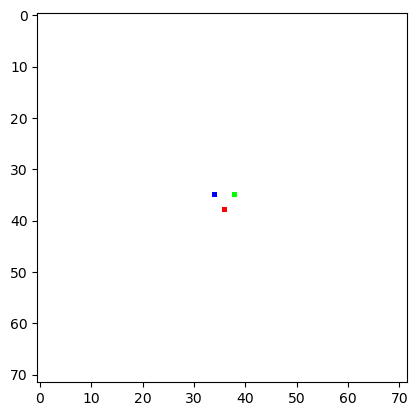

In [15]:
plot_tensor(seed)

In [16]:
from re import split
def create_filename(N,
     hidden_repr,
     hidden_repr_size,
     channel_n=16,
     hidden_size=128):
    return f'C{N}_{hidden_repr}-{hidden_repr_size}_channeln-{channel_n}_hiddensz-{hidden_size}'

def split_filename(filename):
    """Helper for below functions.
        Splits a string `filename` into all the important
        arguments necessary to load model and other saved
        objects.
        Note: This is very hardcoded so users should be mindful.
    """
    split_name = split('_|-|C', filename)
    assert len(split_name) == 8
    N = int(split_name[1])
    hidden_repr = split_name[2]
    hidden_repr_size = int(split_name[3])
    channel_n = int(split_name[5])
    hidden_size = int(split_name[7])
    return N, hidden_repr, hidden_repr_size, channel_n, hidden_size    

def get_model(filename, device=device):
    """Wrapper for `load_ca_model` function in custom-made
        utils package, that returns a loaded torch model
        given a filename generated by `create_filename`.
        Serves as a string parser for `filename`.
    
    :param filename: str, name of stored PyTorch model
    """
    N, hidden_repr, hidden_repr_size, channel_n, hidden_size = split_filename(filename)
    return load_ca_model(CAModel, filename, 
                         N=N,
                         hidden_repr=hidden_repr,
                         hidden_repr_size=hidden_repr_size,
                         channel_n=channel_n,
                         hidden_size=hidden_size, 
                         device=device)           

To train any particular model, change the arguments that are used to instantiate the `CAModel` class, and make sure to make the appropriate changes to the `create_filename` function in order to properly save the model. 

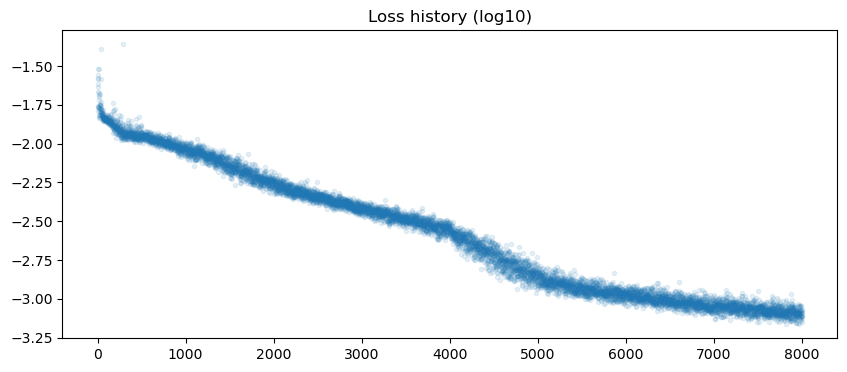

CPU times: user 239 ms, sys: 5.75 ms, total: 245 ms
Wall time: 339 ms


In [17]:
%%time

if TRAIN:
    
    # Sample way to train an individual model
    ca = CAModel(N=6,
                 hidden_repr='regular',
                 hidden_repr_size=48, # this is 16*3
                 channel_n=CHANNEL_N,
                 hidden_size=HIDDEN_SIZE
                ).to(device)

    train = Train(ca, seed.to(device), pad_target.to(device))
    loss_log, elapsed_time = train.train(n_steps=8001)

    filename = create_filename(N=6,
                 hidden_repr='regular',
                 hidden_repr_size=48,
                 channel_n=CHANNEL_N,
                 hidden_size=HIDDEN_SIZE)

    # Save stuff
    save_ca_model(ca, filename)
    save_np_array(loss_log, filename)
    save_np_array(elapsed_time, filename, foldername="train_time")

else:
    filename = create_filename(6, 'regular', 48)
    ca = get_model(filename)
    loss_log = load_np_array(filename)
    plot_loss(loss_log)

<h2>Experiments</h2>

Now that we have all the necessary processing to train our equivariant model, as well as to load saved training instances, we can evaluate our results.

We start by plotting the loss history of several of our models to get a rough idea of the various model performances. Note that the plot displays the log10 loss of each model.

We first define a helper function which will be useful in comparing the performance between two models:

In [24]:
def compare_models(model1, model2, seed, pad_target, n_steps, N=4, titles=None, name=None, device=torch.device('cuda')):
    """Compare the performance of two models on different input transformations.
    
    :param model1: PyTorch model object, first model to compare
    :param model2: PyTorch model object, second model to compare
    :param seed: PyTorch tensor, starting seed pixel to be transformed according to group act
    :param N: int, optional, number of group elements from the cyclic group C_N
    :param titles: list, titles of axes, must be length 2
    :param pad_target: PyTorch tensor, padded target for model to learn
    :param name: str, file name to which to save generated figure
    :param device: PyTorch device
    """

    loss_f = nn.MSELoss()
    
    # Prepare figure
    # fig, axs = plt.subplots(N, 4, figsize=(10,4))
    fig, axs = plt.subplots(N, 4)
    axs[0][0].set_title("Initial seed")
    
    if titles is None:
        axs[0][1].set_title("Original")
        axs[0][2].set_title("Equivariant")
    else:
        axs[0][1].set_title(titles[0])
        axs[0][2].set_title(titles[1])
    axs[0][3].set_title("Target")

    with torch.no_grad():

        for e in range(N):
            
          if len(pad_target.shape) < 4:
              target = torch.repeat_interleave(pad_target[None, ...], seed.shape[0], dim=0)
          else:
              target = pad_target            

          # Apply group transformation
          init, target = rotate(seed, N, e), rotate(target, N, e)
            
          # Move to device
          x1, model1, model2, target = init.to(device), model1.to(device), model2.to(device), target.to(device)
          x2 = x1.clone()

          # Run the model for `n_steps`
          for _ in tqdm.trange(n_steps):
              x1 = model1(x1)
              x2 = model2(x2)

          # Plot the axes
          axs[e][0].imshow(clip_tensor(init[0, ..., :4]))
          axs[e][0].set_axis_off()

          axs[e][1].imshow(clip_tensor(x1[0, ..., :4]))
          axs[e][1].set_axis_off()

          axs[e][2].imshow(clip_tensor(x2[0, ..., :4]))
          axs[e][2].set_axis_off()          

          axs[e][3].imshow(clip_tensor(target[0, ...]))
          axs[e][3].set_axis_off()    
          
        fig.tight_layout()
            
        # Save figure if name not None
        if name is not None:     
          fig.savefig(name, format='png')      
          print(f"Saved figure as {name}.") 

        fig.show() 

In [19]:
# Load all saved models and their respective loss logs

filename1 = create_filename(4, 'regular', 16)
filename2 = create_filename(4, 'regular', 32)
filename3 = create_filename(4, 'regular', 48)
filename4 = create_filename(4, 'regular', 64)

ca_16 = get_model(filename1)
ca_32 = get_model(filename2)
ca_48 = get_model(filename3)
ca_64 = get_model(filename4)
    
ca6_48 = get_model(create_filename(6, 'regular', 48))
ca8_32 = get_model(create_filename(8, 'regular', 32))
ca8_48 = get_model(create_filename(8, 'regular', 48))
ca8_64 = get_model(create_filename(8, 'regular', 64))
ca8_80 = get_model(create_filename(8, 'regular', 80))
            
ca_trivial = get_model(create_filename(4, 'trivial', 48))

# Load loss logs
loss_16 = load_np_array(filename1)
loss_32 = load_np_array(filename2)
loss_48 = load_np_array(filename3)
loss_64 = load_np_array(filename4)

loss6_48 = load_np_array(create_filename(6, 'regular', 48))
loss8_32 = load_np_array(create_filename(8, 'regular', 32))
loss8_48 = load_np_array(create_filename(8, 'regular', 48))
loss8_64 = load_np_array(create_filename(8, 'regular', 64))
loss8_80 = load_np_array(create_filename(8, 'regular', 80))

loss_trivial = load_np_array(create_filename(4, 'trivial', 48))

Showing training history for all trained models equivariant under C_4


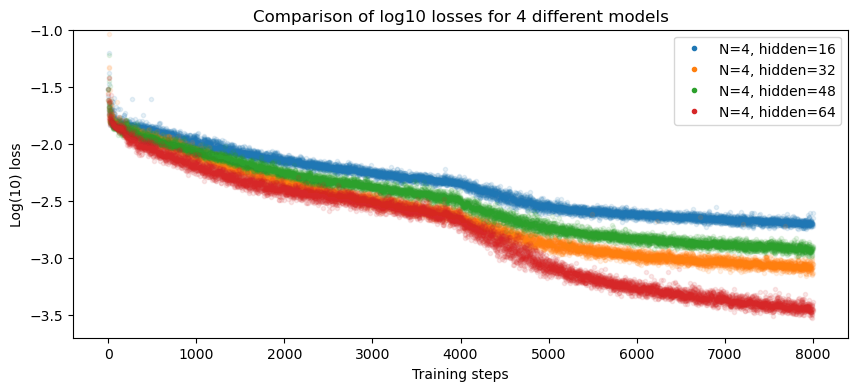

In [22]:
print("Showing training history for all trained models equivariant under C_4")
plot_losses([loss_16, loss_32, loss_48, loss_64],
           ["N=4, hidden=16", "N=4, hidden=32", "N=4, hidden=48",
           "N=4, hidden=64"], name="ca_N=4_loss_log.png")

Showing training history for all trained models equivariant under C_8


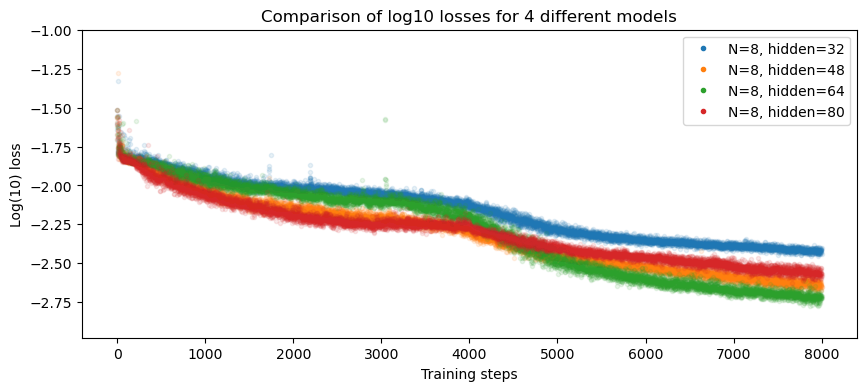

In [23]:
print("Showing training history for all trained models equivariant under C_8")
plot_losses([loss8_32, loss8_48, loss8_64, loss8_80],
           ["N=8, hidden=32", "N=8, hidden=48",
           "N=8, hidden=64", "N=8, hidden=80"], name="ca_N=8_loss_log.png")

As we can see from the above two plots, the neural network is able to converge in all cases, but does not achieve as good performance overall when trained to be equivariant under $C_8$ rather than $C_4$. There could be several reasons for this, but a likely one is that the current architecture is not expressive enough to allow for the additional kernel constraints necessary to make the model equivariant under larger group elements. Additionally, we may just need to train for significantly longer periods of time to achieve better performance. However, these models already require training time that is significantly longer than the original model's, and parameter fine-tuning is not the main focus of this study. We hypothesize that augmenting the dense layer of the network (that was left unchanged from the original model), should not have a significant effect since the size of the dense layer is shown to be sufficient in the original model. The poor performance here is likely due to an inefficient computation of the perception layer, which must continue to be improved.

On a separate note, we should point out that interpolation is likely to be a major issue with these models due to the small 3x3 neighbourhood. A potential fix would be to either augment the size of this neighbourhood, or to redesign our equivariance approach by decomposing the resultant perception vector into scalars and vectors and preserving equivariance throughout the dense layer. This would keep the model from having to re-map to a cartesion plane after every layer which would be helpful in dealing with interpolation issues.

As we can see from the below cell, the model is able to successfully rotate the lizard at multiples of 90 degrees, however it struggles to do so successfully at angles that would require interpolation. This is a current limitation of our design that would likely require either one of the two approaches mentioned above in order to be fixed.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 503.42it/s]


Saved figure as ca_N=8_output.png.


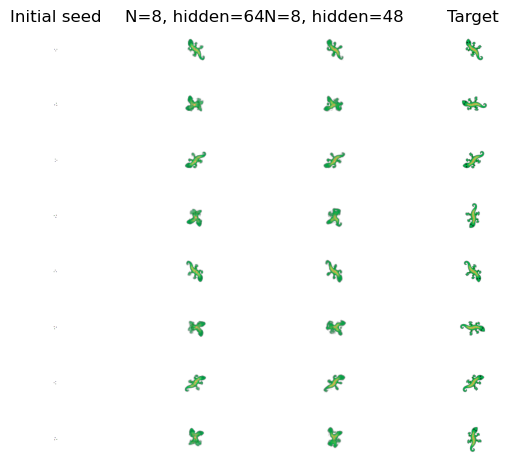

In [25]:
compare_models(ca8_64, ca8_48, seed, pad_target, n_steps=120, N=8,
               titles=['N=8, hidden=64', 'N=8, hidden=48'], device=device, name="ca_N=8_output.png")

Now we examine the performance of several of our best models that achieve equivariance under $C_4$:

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 483.59it/s]


Saved figure as ca_N=4_output.png.


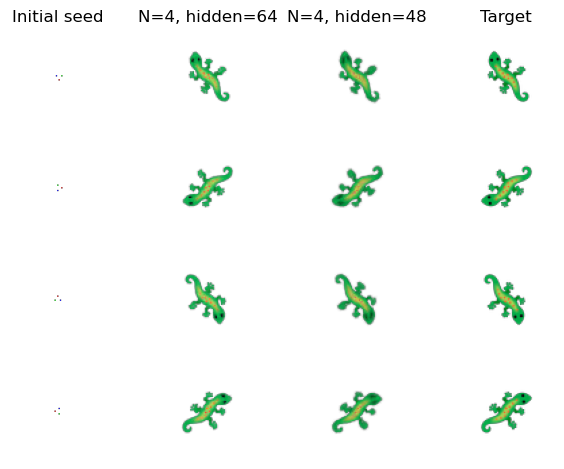

In [26]:
compare_models(ca_64, ca_48, seed, pad_target, n_steps=120,
               titles=['N=4, hidden=64', 'N=4, hidden=48'], device=device, name="ca_N=4_output.png")

From the cell above we can see that the model succeeds at reconstructing the target at multiples of 90-degree rotations. We additionally observe that the model with more hidden feature fields transforming under the regular representation appears to reconstruct the target more successfully (the eyes of the lizard are significantly more well-defined). This is consistent with the plot of the various losses shown above. It also makes sense conceptually, because more feature fields provides the model with greater expressive power. 

Interestingly enough, from the plot of losses for $C_4$ shown above, we see that the model with 32 internal feature fields appears to train slightly better than the model with 48 internal feature fields. The below cell compares the two models visually:

100%|█████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 434.89it/s]


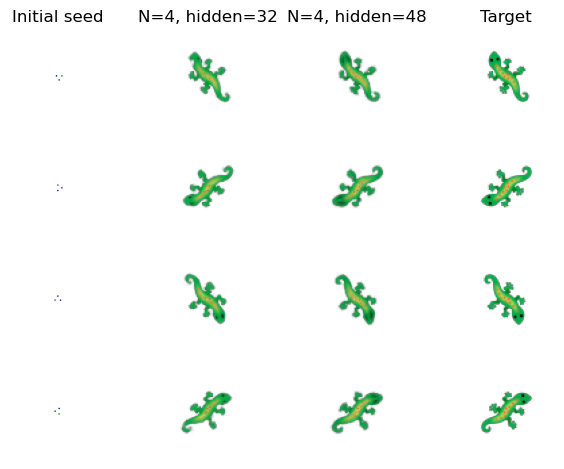

In [28]:
compare_models(ca_32, ca_48, seed, pad_target, n_steps=120,
               titles=['N=4, hidden=32', 'N=4, hidden=48'], device=device)

The model with 32 hidden feature fields does appear to give some greater definition around certain parts of the target (for exapmle, the eyes look a bit more well-defined and the red dots are slightly more discretized), however we also observe some obvious deficiencies, such as missing parts of the lizard.

Lastly, we also decided to experiment with using feature fields transforming under the trivial representation as our hidden fields. On one note, because the output of the perception layer must eventually map to scalars, we wanted to experiment with using a hidden representation which already produces invariant outputs. However, we hypothesize that this should largely fail as it is really limiting the model's ability to capture any sense of gradients in a cell's perceptive field. Indeed, the original paper uses sobel filters to capture gradients in the x and y direction, while using feature fields transforming under the trivial representation would prevent the model from capturing such information. This is indeed what we observe below.

Showing training history for all trained models equivariant under C_4


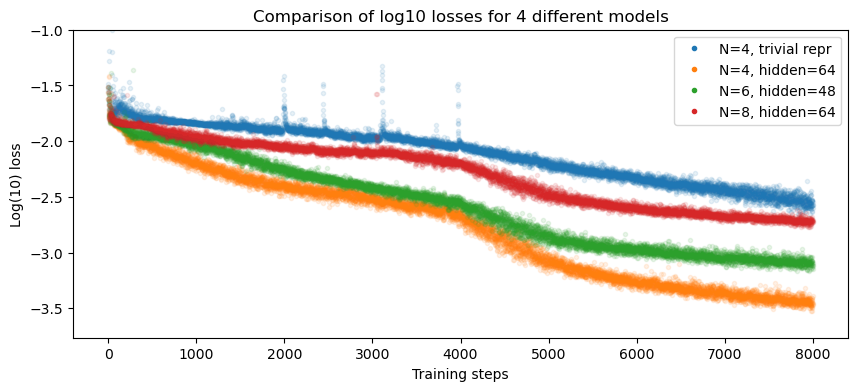

In [29]:
print("Showing training history for all trained models equivariant under C_4")
plot_losses([loss_trivial, loss_64, loss6_48, loss8_64],
           ["N=4, trivial repr", "N=4, hidden=64", "N=6, hidden=48",  "N=8, hidden=64"])

For comparison, the abolve plot shows the best model performance for equivariance under $C_4$ and $C_8$, along with the performance of the model using only the trivial representation. We observe poor performance on the part of the latter.

We additionally show a model trained to be equivariant under $C_6$, as an attempt to find some middle ground between $C_4$ and $C_6$, so to speak. We observe that in the case for $C_6$ the model is able to converge to a lower loss value than for $C_8$, despite the fact that the $C_8$ model has 64 hidden feature fields, as opposed to 48. This suggests that achieving equivariance under a larger group is significantly harder and requires significantly more expressive power.

Nevertheless, when we visualize the results of both the trivial and $C_6$ model, we still observe very poor interpolation results. This is expected for the trivial model as it is trained to be equivariant under $C_4$, but even the attempt at reconstruction in the original orientation is visually quite poor, which is supported by our hypotheses above.

100%|█████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 522.41it/s]


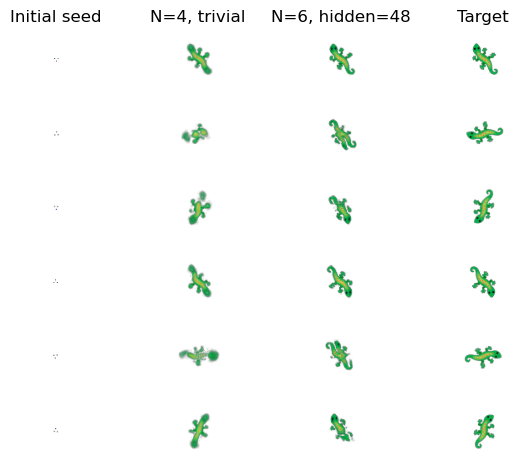

In [31]:
compare_models(ca_trivial, ca6_48, seed, pad_target, n_steps=120, N=6,
               titles=['N=4, trivial', 'N=6, hidden=48'], device=device)

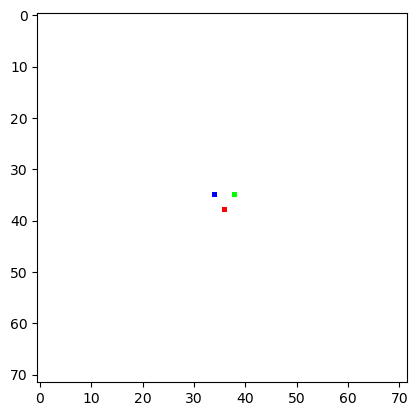

In [32]:
plot_tensor(seed)

Finally, we compare the performance of our best model under $C_4$ with the performance of the original model, on 90-degree rotations. For this, we retrain the original model starting from the same asymmetric seed as the equivariant models (note that the original model does not use an asymmetric seed, but a single seed pixel in the center).

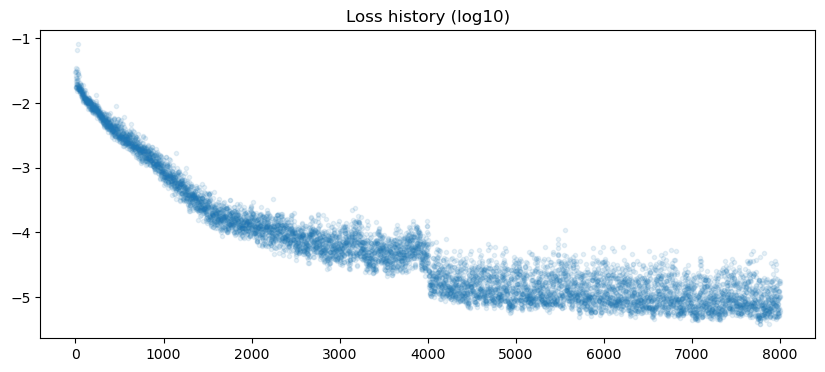

Training took approximately 20.2793 minutes
CPU times: user 216 ms, sys: 5.57 ms, total: 221 ms
Wall time: 235 ms


In [28]:
%%time

# Original CA implementation training instance on asymmetric seed

filename = "original_model_asym"
if TRAIN:
    ca_original_asym = CAModelOriginal().to(device)
    train_original_asym = Train(ca_original_asym, seed.to(device), pad_target.to(device))

    loss_log_original_asym, elapsed_time_original_asym = train_original_asym.train(n_steps=8001)

    # Save stuff
    save_ca_model(ca_original_asym, filename)
    save_np_array(loss_log_original_asym, filename)
    save_np_array(elapsed_time_original_asym, filename, foldername="train_time")
else:
    ca_original_asym = load_ca_model(CAModelOriginal, filename, device=device)
    loss_log_original_asym = load_np_array(filename)
    elapsed_time_original_asym = load_np_array(filename, foldername='train_time')

    plot_loss(loss_log_original_asym)
    print(f"Training took approximately {elapsed_time_original_asym.item()} minutes")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 627.28it/s]


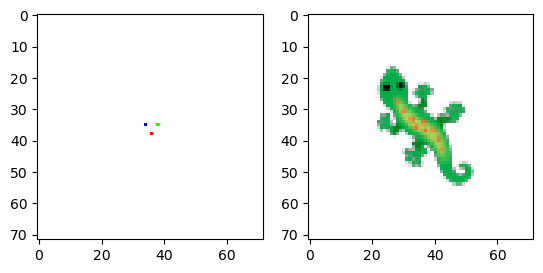

In [29]:
_ = simulate_model(ca_original_asym, seed.unsqueeze(0), 90, device=device)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 554.87it/s]


Saved figure as ca_final_comparisons.png.


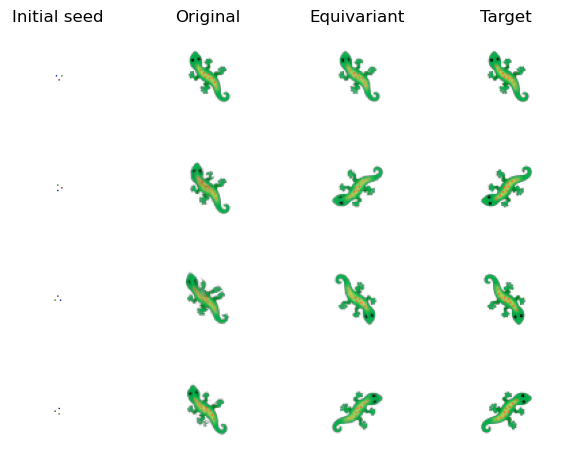

In [30]:
compare_models(ca_original_asym, ca_64, seed, pad_target, n_steps=90, device=device, name="ca_final_comparisons.png")

From the above, we see that while the original model fails to rotate its predicted reconstruction of the target, the equivariant model succeeds. Therefore we appear to have succeeded in constructing a neural network which is equivariant under transformations according to the group $C_4$.

Finally, we make a video showcasing the growth process of our models trained to be equivariant under $C_4$, with the best model being included on the right.

In [36]:
N = 4
n_steps = 130

models = [ca_16, ca_32, ca_48, ca_64]
out_fn = 'equivariant_growth.mp4'
x = torch.repeat_interleave(seed[None, :, :, :], len(models), dim=0).detach().cpu()
with VideoWriter(out_fn) as vid:
  for i in tqdm.trange(n_steps):
    vis = np.hstack(to_rgb(x))
    vid.add(zoom(vis, 2))
    for ca, xk in zip(models, x):
      if i == 30:
          ca_in = rotate(xk[None, ...], N, 3).to(device)
      else:
          ca_in = xk[None, ...].to(device)
      xk[:] = ca(ca_in).detach().cpu()[0]

# Make a VideoFileClip object and then write it 
clip = mvp.VideoFileClip(out_fn)
clip.write_videofile(f'{out_fn}')

mvp.ipython_display(out_fn)

100%|██████████████████████████████████████████████████████████████████████████| 130/130 [00:01<00:00, 67.17it/s]


Moviepy - Building video equivariant_growth.mp4.
Moviepy - Writing video equivariant_growth.mp4



Moviepy - Done !
Moviepy - video ready equivariant_growth.mp4


<h2>Conclusion</h2>

In this work we present an updated method for simulating the growth process of a self-organizing system. This self-organizing is known as a cellular automata, which is a discrete model for computation based on iterative updates of a system according to a fixed set of rules, where each discrete cell is updated according to information from its immediate, 3x3 neighbourhood.

Cellular automata are of interest to researchers because they have the ability to generate seemingly arbitrarily complex simulations with a relatively simple set of rules, given some initial condition. Some rules have even been proven to be <a href="https://arxiv.org/pdf/0906.3248.pdf">turing complete</a>. Given the complex nature of these simulations, it may be of interest to have a model which is capable of generating a set of rules that can simulate said system.

In a 2020 blog post, <a href="https://distill.pub/2020/growing-ca/">A Mordvintsev, et al.</a> present one of the first major successes towards this goal. Using a small neural network, they are able to learn a set of CA "rules" (in practice, weight matrices), which can grow into some target image from a single seed pixel. Furthermore, this is done purely via local message passing. 

However, despite the successes of this original model several limitations remain. The most obvious one is that the model has no good capability for growing the target in an orientation different from that in which it was trained. Even though the authors propose a method for doing so using rotation matrices, this still does not perform very well as the model fails in certain cases where a rotation is applied midway through training, for example.

A <a href="https://doi.org/10.48550/arXiv.2205.01681">follow-up paper</a> proposed by those same authors uses a modified loss function to make an isotropic version of their original work. In this new paper, they propose the methodology of using an asymmetric seed as the starting state of the network, as opposed to a single seed in the center. 

In retrospect, our model is a cleaner implementation of a CA network that is equivariant to $C_4$. However, our work has some obvious limitations. The most prominent one being that our target is only equivariant to a very limited subset of rotations, instead of $SO(2)$, which, presumably, is what the isotropic NCA paper achieves. 

Nevertheless, constrained to the group of 90-degree rotations, our model performs quite well, with minimal changes to the original work. Future work may involve constructing equivariant cellular automata in 3D instead of 2D, using the <a href="https://github.com/e3nn/e3nn">e3nn</a> library for example. This would provide for broader applications of cellular automaton-based models.

<h2>References</h2>

S Wolfram, <i>Theory and Applications of Cellular Automata</i>. World Scientific, 1986.

M Cook, <i>A Concrete View of Rule 110 Computation</i>. arXiv, 2009. https://arxiv.org/pdf/0906.3248.pdf

A Mordvintsev, et al. <i>Growing Isotropic Neural Cellular Automata</i>. arXiv, 2022. 
https://doi.org/10.48550/arXiv.2205.01681

J Springer, G Kenyon, <i>It's Hard For Neural Networks To Learn The Game Of Life</i>. International Joint Conference on Neural Networks, 2021. https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9534060&tag=1

N H Wolff, J A Hertz, <i>Learning Cellular Automaton Dynamics with Neural Networks</i>. NeurIPS, 1992. https://proceedings.neurips.cc/paper/1992/file/d6c651ddcd97183b2e40bc464231c962-Paper.pdf

D Grattarola, et al. <i>Learning Graph Cellular Automata</i>. NeurIPS, 2021. https://proceedings.neurips.cc/paper/2021/hash/af87f7cdcda223c41c3f3ef05a3aaeea-Abstract.html

R Palm, et al. <i>Variational Neural Cellular Automata</i>. ICLR, 2022. https://openreview.net/pdf?id=7fFO4cMBx_9

M Weiler, G Cesa. <i>General E(2)-Equivariant Steerable CNNs</i>. NeurIPS, 2019. https://arxiv.org/pdf/1911.08251.pdf